Load Libraries

In [5]:
%matplotlib inline
#%matplotlib qt
import matplotlib.pyplot as plt
import scipy
import math
import pathlib


from sklearn.metrics import mean_squared_error
#from pydmd.plotter import plot_eigs

import numpy as np
from numpy import dot, multiply, diag, power
from numpy import pi, exp, sin, cos
from numpy.linalg import inv, eig, pinv, solve
from scipy.linalg import svd, svdvals
from math import floor, ceil # python 3.x

import scipy.io

import pandas as pd
import csv
from dmdc import DMDc

2 Syntetic Complex dataset with complete U matrix (200 x 7160)
3 Syntetic Complex dataset with U[161,:] (fifth input with no delay)
    # matrix plot
    matrix_xlabel = 'State'; matrix_ylabel = 'Samples'
    # array plot (when the plot is of one state)
    array_xlabel = 'Samples'; array_ylabel = 'State'; array_title = 'State: x_' + str(column_to_show + 1)

4 V2G dataset with state NOT delayed and inputs NOT delayed
5 V2G datasets with state delayed and inputs NOT delayed
6 V2G datasets with state delayed and inputs delayed

dataset = 5
    XU1_DMDc 1 meteo + aggregated
    XU2_DMDc 1 aggregated
    XU3_DMDc 1 meteo (no rhum_t) + aggregated
    XU4_DMDc 1 meteo(no rhum_t)+aggregated(no holidays)
    XU5_DMDc 1 aggregated(no holidays)

dataset = 6 
    XU1_DMDc meteo + aggregated
    XU2_DMDc aggregated
    XU3_DMDc meteo (no rhum_t) + aggregated
    XU4_DMDc meteo(no rhum_t)+aggregated(no holidays)
    XU5_DMDc aggregated(no holidays)

    # matrix plot
    matrix_xlabel = 'Available Aggregated Capacity'; matrix_ylabel = 'Samples (30 minutes)'
    # array plot (when the plot is of one state)
    array_xlabel = 'Samples (30 minutes)'; array_ylabel = 'AAC'; array_title = 'State: ACC_' + str(column_to_show + 1)


PARAMETERS SETTING

In [6]:
#insert path in wich to load .mat files
#load the training experimental file
#root_path = r'C:\Users\franc\Dropbox\Scuola\Ruolo\2022-23 Messina PHD\V2Grid Software\V2G-DMD\stati ritardati ed ingressi ritardati\Experimental Data'



notebook_dir = pathlib.Path().resolve()

# Build a relative path to the data folder
root_path = notebook_dir.parent.parent / 'Data' / 'Rome' / 'ModelInputData'

#experimental dateset number
dataset=6
cut_negative_AAC=True

#this parameter is used to decide which column to show, 47 is the variable related to the experiment zero.
column_to_show = 47

''':param svd_rank: the rank for the truncation; If 0, the method computes the optimal rank and uses it for truncation;
 if positive interger, the method uses the argument for the truncation; if float between 0 and 1,the rank is the number 
 of the biggest singular values that are needed to reach the 'energy' specified by `svd_rank`; if -1, the method does
not compute truncation.'''
svd_rank_set = -1


#sampling time 
sampling_time_hour = 0.5

#prediction step in hour
prediction_k_hour = 1

#prediction step in samples
prediction_k = math.floor(prediction_k_hour // sampling_time_hour)

#path_for_load_experimental_train = root_path+  r'\Train\XU' + str(dataset)+'train_DMDc.mat'
path_for_load_experimental_train = root_path / f'XU{dataset}train_DMDc.mat'

#load the test experimental file
#path_for_load_experimental_valid = root_path+  r'\valid\XU' + str(dataset)+'valid_DMDc.mat'
path_for_load_experimental_test = root_path / f'XU{dataset}test_DMDc.mat'
path_for_load_experimental_valid = root_path / f'XU{dataset}valid_DMDc.mat'

#insert path in which to  save the csv files 
#save the training reconstructed file
#path_for_save_reconstructed_train =  root_path+  r'\Train\XU' + str(dataset)+'train_DMDc_rank_'+str(svd_rank_set)+'_reconstructed_XU' +'predict_'+str(prediction_k_hour)+'h.csv'
#path_for_save_experimental_train =  root_path+  r'\Train\XU' + str(dataset)+'train_DMDc_experimental_XU' + 'predict_'+str(prediction_k_hour)+'h.csv'
path_for_save_reconstructed_train =  root_path / f'XU{dataset}train_DMDc_rank_{svd_rank_set}_reconstructed_XUpredict_{prediction_k_hour}h.csv'
path_for_save_experimental_train =  root_path/  f'XU{dataset}train_DMDc_experimental_XUpredict_{prediction_k_hour}h.csv'

#join ->    _reconstructed_train.csv
#save the test reconstructed file
#path_for_save_reconstructed_test = root_path+  r'\Test\XU' + str(dataset)+'test_DMDc_rank_'+str(svd_rank_set)+'_reconstructed_XU' + str(dataset)+'predict_'+str(prediction_k_hour)+'h.csv'
#path_for_save_experimental_test =  root_path+  r'\Test\XU' + str(dataset)+'test_DMDc_experimental_XU' + str(dataset)+'predict_'+str(prediction_k_hour)+'h.csv'
path_for_save_reconstructed_test = root_path/ f'XU{dataset}test_DMDc_rank_{svd_rank_set}_reconstructed_XU{dataset}predict_{prediction_k_hour}h.csv'
path_for_save_experimental_test =  root_path/ f'XU{dataset}test_DMDc_experimental_XU{dataset}predict_{prediction_k_hour}h.csv'


path_for_save_reconstructed_valid = root_path/ f'XU{dataset}valid_DMDc_rank_{svd_rank_set}_reconstructed_XU{dataset}predict_{prediction_k_hour}h.csv'
path_for_save_experimental_valid =  root_path/ f'XU{dataset}valid_DMDc_experimental_XU{dataset}predict_{prediction_k_hour}h.csv'

#join ->    _reconstructed_test.csv                


# matrix plot
matrix_xlabel = 'Available Aggregated Capacity'
matrix_ylabel = 'Samples (30 minutes)'

# array plot (when the plot is of one state)
array_xlabel = 'Samples (30 minutes)'
array_ylabel = 'AAC'
array_title = 'Predicted AAC at ' + str(prediction_k_hour)+'h'

LOAD DATASET FOR TRAINING

In [7]:
#dataset for traininig
D_mat = scipy.io.loadmat(path_for_load_experimental_train)
D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]
D_train = np.array(D_mat_list)
U_train = np.array(U_mat_list)




PLOT Settings, scale normalization

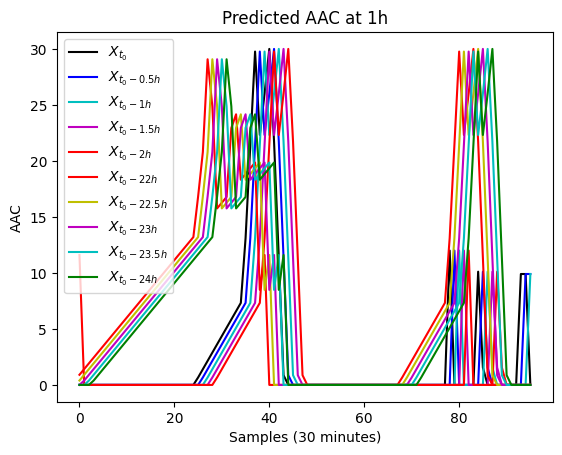

In [8]:
'''from this moment on, nothing needs to be set'''

#if the data are an array 1-D with this instruction they became 2-D
if len(D_train.shape) == 1:
    D_train = D_train[: , np.newaxis].T
if len(U_train.shape) == 1:
    U_train = U_train[: , np.newaxis].T

vmax = np.amax(D_train)
vmin = np.amin(D_train)






#eventually matrix D_train or U_train have different dimensions of columns (snapshots)
if D_train.shape[1] > U_train.shape[1]:
    D_train = D_train[:,:U_train.shape[1]]
else:
    U_train = U_train[:,:D_train.shape[1]]

#eventually matricies D_train or U_train have different dimensions of columns (snapshots) and different dimension from Test matricies
#if path_for_load_experimental_test is not None:
#    if D_test.shape[1] > U_test.shape[1]:
#        D_test = D_test[:,:U_test.shape[1]]
#        max = U_test.shape[1]
#    else:
#        U_test = U_test[:,:D_test.shape[1]]
#        max = D_test.shape[1]

#    D_train = D_train[:,:max]
#    U_train = U_train[:,:max]



#number of rows of the dataset
x_train = np.linspace(0, D_train.shape[0], D_train.shape[0])

#number of columns of the dataset
t_train = np.linspace(0, D_train.shape[1], D_train.shape[1])


#this function allow to make plot like image (it is used to plot matrix values)
def make_plot(X, x=None, y=None, title='', xlabel = None, ylabel = None, vmin = None, vmax = None, ticks = None):
    """
    Plot of the data X
    """
    plt.figure()
    plt.title(title)
    if vmin is not None:
        CS = plt.pcolormesh(x, y, X, vmin = vmin, vmax = vmax, cmap= "viridis")
    else:
        plt.pcolor(X.real)
    plt.colorbar()
    if ticks is not None:
        plt.xticks(np.arange(0, len(X[0]), ticks))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

#make_plot(D_train.T, x=x_train, y=t_train, title = 'Training dataset', xlabel = matrix_xlabel, ylabel = matrix_ylabel)


#plot of the state of the dataset selected
plt.figure()
#valid if considering column_toshow=47
plt.plot( D_train[column_to_show,0:96], 'k', label=r'$X_{t_0}$')
plt.plot( D_train[column_to_show-1,0:96], 'b', label=r'$X_{t_0-0.5h}$')
plt.plot( D_train[column_to_show-2,0:96], 'c', label=r'$X_{t_0-1h}$')
plt.plot( D_train[column_to_show-3,0:96], 'm', label=r'$X_{t_0-1.5h}$')
plt.plot(D_train[column_to_show-4,0:96], 'r', label=r'$X_{t_0-2h}$')
#plt.plot( D_train[column_to_show-5,0:96], 'g', label='-5')
#plt.plot( D_train[column_to_show-6,0:96], 'b', label='-6')
#plt.plot(D_train[column_to_show-7,0:96], 'r', label='-7')
#plt.plot( D_train[column_to_show-8,0:96], 'b', label='-8')
#plt.plot(D_train[column_to_show-9,0:96], 'r', label='-9')
#plt.plot(D_train[column_to_show-12,0:96], 'c', label='-12')
plt.plot(D_train[column_to_show-43,0:96], 'r', label=r'$X_{t_0-22h}$')
plt.plot(D_train[column_to_show-44,0:96], 'y', label=r'$X_{t_0-22.5h}$')
plt.plot(D_train[column_to_show-45,0:96], 'm', label=r'$X_{t_0-23h}$')
plt.plot(D_train[column_to_show-46,0:96], 'c', label=r'$X_{t_0-23.5h}$')
plt.plot(D_train[column_to_show-47,0:96], 'g', label=r'$X_{t_0-24h}$')
plt.title(array_title)
plt.xlabel(array_xlabel)
plt.ylabel(array_ylabel)
plt.legend()
plt.show()


TRAINING SECTION

In [9]:
U_train = U_train[:,1:]

dmdc = DMDc(svd_rank = svd_rank_set)    

dmdc.fit(D_train,U_train)


k-STEP-HAED Reconstruction

In [10]:

DMDc_train_reconstructed = []
#DMDc_train_reconstructed_dayahead = []

#prediction_slots = math.floor(D_train.shape[1] // prediction_k)

for k in range(0, D_train.shape[1]-prediction_k-1):
    D_slot = D_train[: ,k:k+prediction_k-1]
    U_slot = U_train[: ,k:k+prediction_k-1]
    
    #zero_padding_lenght = int(U_train.shape[1] - U_slot.shape[1])
    #zeros_matrix_D = np.zeros([D_train.shape[0], zero_padding_lenght])
    #zeros_matrix_U = np.zeros([U_train.shape[0], zero_padding_lenght])
    #D_slot = np.hstack([D_slot, zeros_matrix_D])
    #U_slot = np.hstack([U_slot, zeros_matrix_U])
    reconstructed_slot = dmdc.reconstructed_data(open_loop = False, X = D_slot, control_input = U_slot, cut_negative_AAC=cut_negative_AAC)
    reconstructed_slot =reconstructed_slot.real 
    #reconstructed_slot_dayahead =reconstructed_slot_complete[:,prediction_k+1:2*prediction_k+1].real 
    DMDc_train_reconstructed.append(reconstructed_slot[column_to_show,-1])
    #DMDc_train_reconstructed_dayahead.append(reconstructed_slot_dayahead)

DMDc_train_reconstructed = np.hstack(DMDc_train_reconstructed)
#DMDc_train_reconstructed_dayahead = np.hstack(DMDc_train_reconstructed_dayahead)

DEBUG windwow

In [11]:
DMDc_train_reconstructed



array([0.        , 0.        , 0.        , ..., 0.05790166, 0.28814687,
       0.28465   ], shape=(9356,))

ELABORATE TRAINING RESULTS

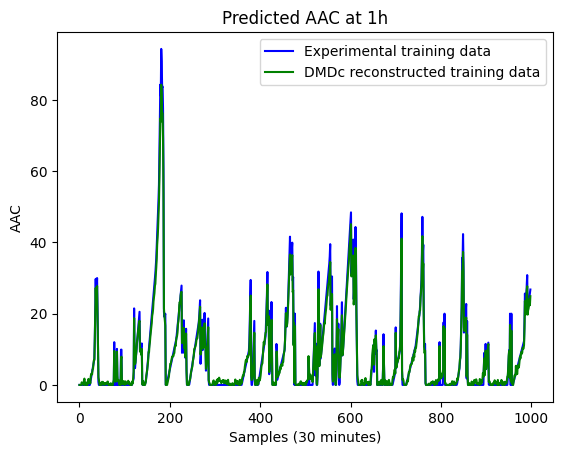

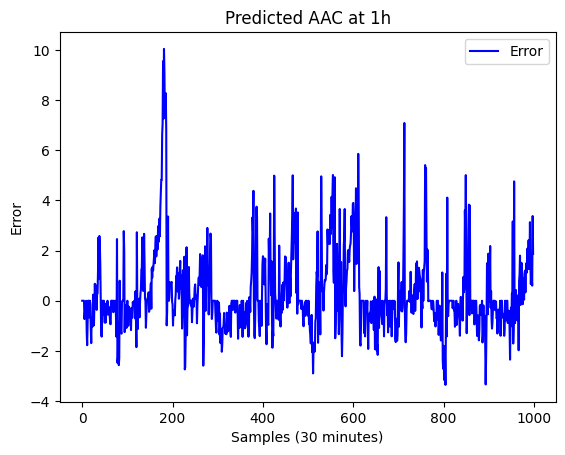

Train KPI: 1h
MSE: signal
1.2959309674082964
1.30e+00
MAPE: signal
7633781627929.577
7.63e+12
MAE: signal
0.74728408738187
7.47e-01
RMSE: signal
1.1383896377815008
1.14e+00
R2: signal
0.9752699442185725
9.75e-01


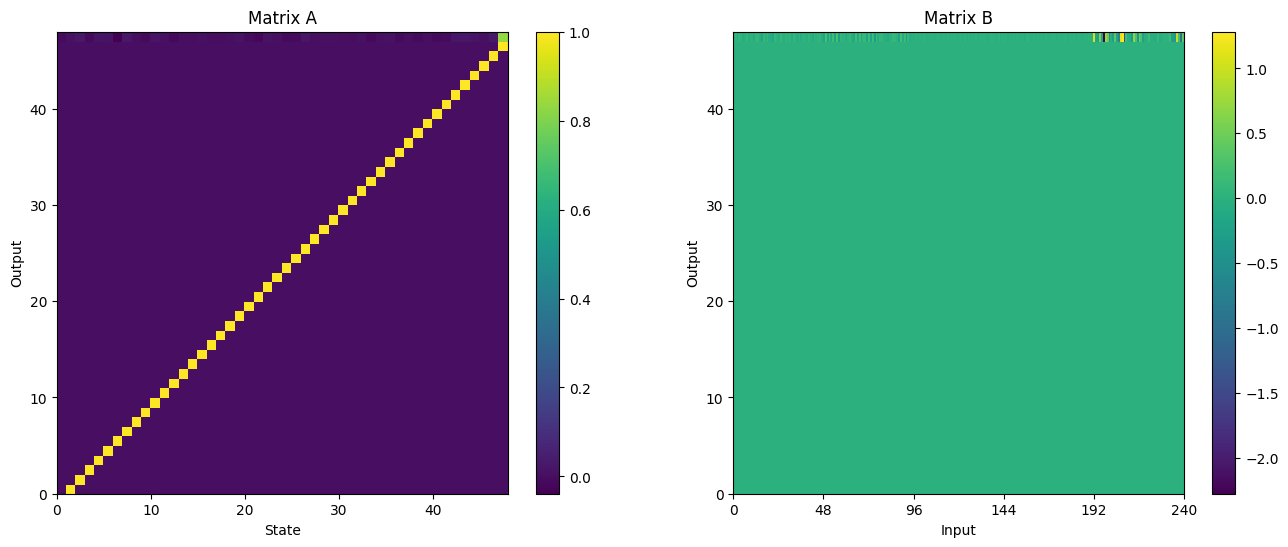

In [ ]:
# troncamento per adattarsi al fatto che la divisione in slot potrebbe lasciare fuori qualcosa
#prendo solo il t_0, e parto dal ritardo 48 campioni per la previsione
D_train_truncated = D_train[column_to_show,:DMDc_train_reconstructed.shape[0]-prediction_k]
DMDc_train_reconstructed_comparison=DMDc_train_reconstructed[:-prediction_k]

#extraction of the matrix A calculation taken from the method reconstruction_data
eigs = np.power(dmdc.eigs, dmdc.dmd_time["dt"] // dmdc.original_time["dt"])
A = np.linalg.multi_dot([dmdc.modes, np.diag(eigs), np.linalg.pinv(dmdc.modes)])

#t_train = t_train[:DMDc_train_reconstructed.shape[1]]

y_true=D_train_truncated
y_pred=DMDc_train_reconstructed_comparison

plt.figure()
plt.title(array_title)
plt.plot(y_true[1:1000], 'b', label='Experimental training data')
#plt.plot(t_train, DMDc_train_reconstructed[column_to_show,:].real, 'g', label='DMDc reconstructed training data')
plt.plot(y_pred[1:1000], 'g', label='DMDc reconstructed training data')
plt.xlabel(array_xlabel)
plt.ylabel(array_ylabel)
plt.legend()
plt.show()

plt.figure()
plt.title(array_title)


error=np.array(y_true) - np.array(y_pred)
plt.plot(error[1:1000], 'b', label='Error')
plt.xlabel(array_xlabel)
plt.ylabel('Error')
plt.legend()
plt.show()


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

def MSE(y_true, y_pred):
    mse_value = mean_squared_error(np.array(y_true.real), np.array(y_pred.real))
    return mse_value

def MAPE (y_true,y_pred):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = mean_absolute_percentage_error(np.array(y_true.real), np.array(y_pred.real))
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = mean_absolute_error(np.array(y_true.real), np.array(y_pred.real))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = math.sqrt(MSE(y_true.real, y_pred.real))
    return rmse_value

def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_true.real), np.array(y_pred.real))
    return r2_value




print("Train KPI: "+str(prediction_k_hour)+"h")
#print("MSE: matrix")
#print((MSE(DMDc_train_reconstructed.T,D_train_truncated.real.T)))
#print("{:.2e}".format(MSE(DMDc_train_reconstructed.T , D_train_truncated.real.T)))
print("MSE: signal")
print((MSE(y_pred,y_true)))
print("{:.2e}".format(MSE(y_pred,y_true)))

#print ("MAPE: ")
#print (MAPE(DMDc_train_reconstructed.T , D_train_truncated.real.T))
#print("{:.2e}".format(MAPE(DMDc_train_reconstructed.T , D_train_truncated.real.T)))
print("MAPE: signal")
print((MAPE(y_pred,y_true)))
print("{:.2e}".format(MAPE(y_pred,y_true)))

#print ("MAE: ")
#print(MAE(DMDc_train_reconstructed.T , D_train_truncated.real.T))
#print("{:.2e}".format(MAE(DMDc_train_reconstructed.T , D_train_truncated.real.T)))
print("MAE: signal")
print((MAE(y_pred,y_true)))
print("{:.2e}".format(MAE(y_pred,y_true)))

#print ("RMSE: ")
#print(RMSE(DMDc_train_reconstructed.T , D_train_truncated.real.T))
#print("{:.2e}".format(RMSE(DMDc_train_reconstructed.T , D_train_truncated.real.T)))
print("RMSE: signal")
print((RMSE(y_pred,y_true)))
print("{:.2e}".format(RMSE(y_pred,y_true)))

#print ("R2: ")
#print(R2(DMDc_train_reconstructed.T , D_train_truncated.real.T))
#print("{:.2e}".format(R2(DMDc_train_reconstructed.T , D_train_truncated.real.T)))
print("R2: signal")
print((R2(y_pred,y_true)))
print("{:.2e}".format(R2(y_pred,y_true)))

#show A and B of the model

plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.title('Matrix A')
plt.pcolor(A.real)
plt.colorbar()
plt.xlabel('State')
plt.ylabel('Output')

plt.subplot(122)
plt.title('Matrix B')
plt.pcolor(dmdc.B)
plt.colorbar()
plt.xticks(np.linspace(0, dmdc.B.shape[1], (U_train.shape[0] // D_train.shape[0]) + 1))
plt.xlabel('Input')
plt.ylabel('Output')

plt.show()

WRITING CSV with TRAINING RESULTS

In [13]:

def writing_csv(path, data):
    with open(path, 'w', newline='') as file_csv:
        writer = csv.writer(file_csv)
        writer.writerows(data)

df = pd.DataFrame()
df['Experimental'] = y_true
df['Reconstructed'] = y_pred
df.to_csv(path_for_save_reconstructed_train, sep=',', encoding='utf-8')


k-Step Ahead TEST Reconstruction

In [ ]:

'''Test of the model'''
#dataset for testing
if path_for_load_experimental_test is not None:
    D_mat = scipy.io.loadmat(path_for_load_experimental_test)

    D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
    U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]

    D_test = np.array(D_mat_list)
    U_test = np.array(U_mat_list)


vmin = np.amax(D_test)
vmax = np.amin(D_test)

U_test = U_test[:,1:]


DMDc_test_reconstructed = []

for k in range(0, D_test.shape[1]-prediction_k-1):
    D_slot = D_test[: ,k:k+prediction_k-1]
    U_slot = U_test[: ,k:k+prediction_k-1]
    reconstructed_slot = dmdc.reconstructed_data(open_loop = False, X = D_slot, control_input = U_slot, cut_negative_AAC=cut_negative_AAC)
    reconstructed_slot =reconstructed_slot.real 
    DMDc_test_reconstructed.append(reconstructed_slot[column_to_show,-1])
   

DMDc_test_reconstructed = np.hstack(DMDc_test_reconstructed)



    # comparison between experimental test and reconstructed test



ELABORATE TEST RESULTS

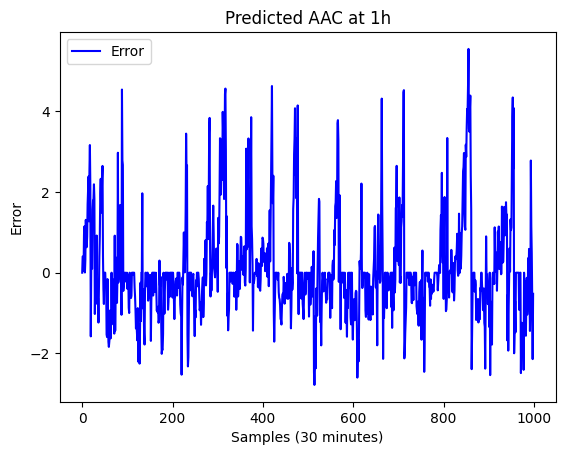

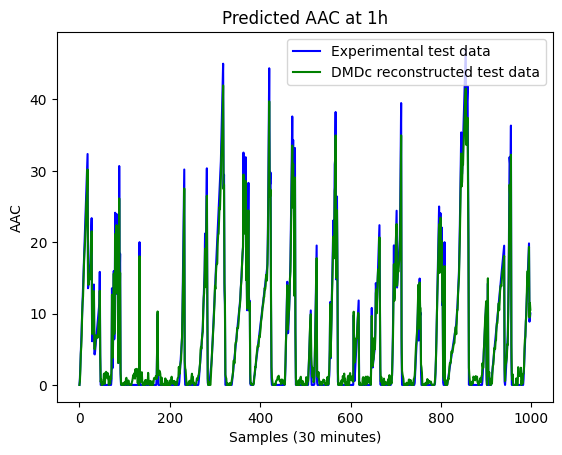

Test KPI: 1h
MSE: signal
1.5459058976564684
1.55e+00
MAPE: signal
13263882013605.691
1.33e+13
MAE: signal
0.8167253755705634
8.17e-01
RMSE: signal
1.2433446415441167
1.24e+00
R2: signal
0.9759386485913648
9.76e-01


In [15]:
# troncamento per adattarsi al fatto che la divisione in slot potrebbe lasciare fuori qualcosa
#prendo solo il t_0, e parto dal ritardo 48 campioni per la previsione
D_test_truncated = D_test[column_to_show,:DMDc_test_reconstructed.shape[0]-prediction_k]
DMDc_test_reconstructed_comparison=DMDc_test_reconstructed[:-prediction_k]

plt.figure()
plt.title(array_title)

y_test_true=D_test_truncated
y_test_pred=DMDc_test_reconstructed_comparison
error=np.array(y_test_true) - np.array(y_test_pred)
plt.plot(error[1:1000], 'b', label='Error')
plt.xlabel(array_xlabel)
plt.ylabel('Error')
plt.legend()
plt.show()

plt.figure()
plt.title(array_title)
plt.plot(y_test_true[1:1000], 'b', label='Experimental test data')
plt.plot(y_test_pred[1:1000], 'g', label='DMDc reconstructed test data')
plt.xlabel(array_xlabel)
plt.ylabel(array_ylabel)
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

def MSE(y_true, y_pred):
    mse_value = mean_squared_error(np.array(y_true.real), np.array(y_pred.real))
    return mse_value

def MAPE (y_true,y_pred):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = mean_absolute_percentage_error(np.array(y_true.real), np.array(y_pred.real))
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = mean_absolute_error(np.array(y_true.real), np.array(y_pred.real))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = math.sqrt(MSE(y_true.real, y_pred.real))
    return rmse_value

def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_true.real), np.array(y_pred.real))
    return r2_value


print("Test KPI: "+str(prediction_k_hour)+"h")
print("MSE: signal")
print((MSE(y_test_pred,y_test_true)))
print("{:.2e}".format(MSE(y_test_pred,y_test_true)))

#print ("MAPE: ")
print("MAPE: signal")
print((MAPE(y_test_pred,y_test_true)))
print("{:.2e}".format(MAPE(y_test_pred,y_test_true)))

#print ("MAE: ")
print("MAE: signal")
print((MAE(y_test_pred,y_test_true)))
print("{:.2e}".format(MAE(y_test_pred,y_test_true)))

#print ("RMSE: ")
print("RMSE: signal")
print((RMSE(y_test_pred,y_test_true)))
print("{:.2e}".format(RMSE(y_test_pred,y_test_true)))

#print ("R2: ")

print("R2: signal")
print((R2(y_test_pred,y_test_true)))
print("{:.2e}".format(R2(y_test_pred,y_test_true)))


Write TEST RESULTS on CSV

In [ ]:
def writing_csv(path, data):
    with open(path, 'w', newline='') as file_csv:
        writer = csv.writer(file_csv)
        writer.writerows(data)

df = pd.DataFrame()
df['Experimental'] = y_true
df['Reconstructed'] = y_pred
df.to_csv(path_for_save_reconstructed_test, sep=',', encoding='utf-8')

Validation

In [16]:
#dataset for testing
#if path_for_load_experimental_test is not None:
   
    #if the data are an array 1-D with this instruction they became 2-D
#    if len(D_test.shape) == 1:
#        D_test = D_test[:, np.newaxis].T
#   if len(U_test.shape) == 1:
#        U_test = U_test[:, np.newaxis].T

'''Test of the model'''
#dataset for testing
if path_for_load_experimental_valid is not None:
    D_mat = scipy.io.loadmat(path_for_load_experimental_valid)

    D_mat_list = [[element for element in upperElement] for upperElement in D_mat['X']]
    U_mat_list = [[element for element in upperElement] for upperElement in D_mat['U']]

    D_valid = np.array(D_mat_list)
    U_valid = np.array(U_mat_list)


vmin = np.amax(D_valid)
vmax = np.amin(D_valid)

U_valid = U_valid[:,1:]


DMDc_valid_reconstructed = []

for k in range(0, D_valid.shape[1]-prediction_k-1):
    D_slot = D_valid[: ,k:k+prediction_k-1]
    U_slot = U_valid[: ,k:k+prediction_k-1]
    reconstructed_slot = dmdc.reconstructed_data(open_loop = False, X = D_slot, control_input = U_slot, cut_negative_AAC=cut_negative_AAC)
    reconstructed_slot =reconstructed_slot.real 
    DMDc_valid_reconstructed.append(reconstructed_slot[column_to_show,-1])
   

DMDc_valid_reconstructed = np.hstack(DMDc_valid_reconstructed)



    # comparison between experimental test and reconstructed valid



elaborate Validation results

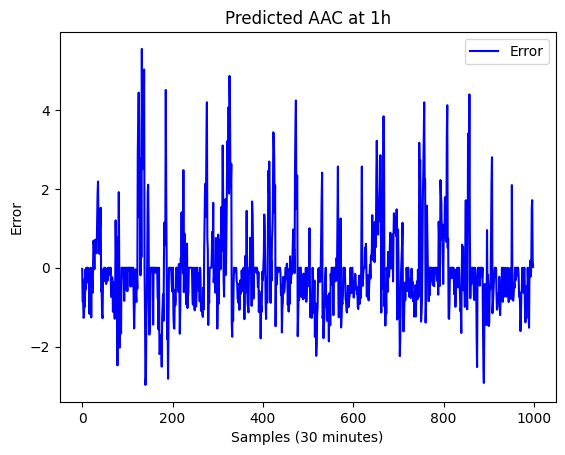

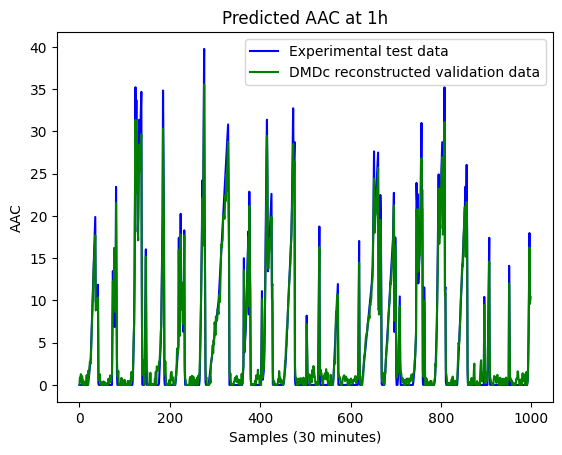

Validation KPI: 1h
MSE: signal
1.3562307454411175
1.36e+00
MAPE: signal
9888922756934.549
9.89e+12
MAE: signal
0.7852982923921197
7.85e-01
RMSE: signal
1.164573203126844
1.16e+00
R2: signal
0.9738901414927018
9.74e-01


In [17]:
# troncamento per adattarsi al fatto che la divisione in slot potrebbe lasciare fuori qualcosa
#prendo solo il t_0, e parto dal ritardo 48 campioni per la previsione
D_valid_truncated = D_valid[column_to_show,:DMDc_valid_reconstructed.shape[0]-prediction_k]
DMDc_valid_reconstructed_comparison=DMDc_valid_reconstructed[:-prediction_k]

plt.figure()
plt.title(array_title)

y_valid_true=D_valid_truncated
y_valid_pred=DMDc_valid_reconstructed_comparison
error=np.array(y_valid_true) - np.array(y_valid_pred)
plt.plot(error[1:1000], 'b', label='Error')
plt.xlabel(array_xlabel)
plt.ylabel('Error')
plt.legend()
plt.show()

plt.figure()
plt.title(array_title)
plt.plot(y_valid_true[1:1000], 'b', label='Experimental test data')
plt.plot(y_valid_pred[1:1000], 'g', label='DMDc reconstructed validation data')
plt.xlabel(array_xlabel)
plt.ylabel(array_ylabel)
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

def MSE(y_true, y_pred):
    mse_value = mean_squared_error(np.array(y_true.real), np.array(y_pred.real))
    return mse_value

def MAPE (y_true,y_pred):   #MEAN ABSOLUTE PERCENTAGE ERROR
    mape = mean_absolute_percentage_error(np.array(y_true.real), np.array(y_pred.real))
    return mape

def MAE(y_true, y_pred):     #MEAN ABSOLUTE ERROR
    mae_value = mean_absolute_error(np.array(y_true.real), np.array(y_pred.real))
    return mae_value

def RMSE(y_true, y_pred):     #ROOT MEAN SQUARED ERROR
    rmse_value = math.sqrt(MSE(y_true.real, y_pred.real))
    return rmse_value

def R2(y_true, y_pred):
    r2_value = r2_score(np.array(y_true.real), np.array(y_pred.real))
    return r2_value


print("Validation KPI: "+str(prediction_k_hour)+"h")
print("MSE: signal")
print((MSE(y_valid_pred,y_valid_true)))
print("{:.2e}".format(MSE(y_valid_pred,y_valid_true)))

#print ("MAPE: ")
print("MAPE: signal")
print((MAPE(y_valid_pred,y_valid_true)))
print("{:.2e}".format(MAPE(y_valid_pred,y_valid_true)))

#print ("MAE: ")
print("MAE: signal")
print((MAE(y_valid_pred,y_valid_true)))
print("{:.2e}".format(MAE(y_valid_pred,y_valid_true)))

#print ("RMSE: ")
print("RMSE: signal")
print((RMSE(y_valid_pred,y_valid_true)))
print("{:.2e}".format(RMSE(y_valid_pred,y_valid_true)))

#print ("R2: ")

print("R2: signal")
print((R2(y_valid_pred,y_valid_true)))
print("{:.2e}".format(R2(y_valid_pred,y_valid_true)))


Write Validation data on CSV

In [ ]:
def writing_csv(path, data):
    with open(path, 'w', newline='') as file_csv:
        writer = csv.writer(file_csv)
        writer.writerows(data)

df = pd.DataFrame()
df['Experimental'] = y_true
df['Reconstructed'] = y_pred
df.to_csv(path_for_save_reconstructed_valid, sep=',', encoding='utf-8')